In [2]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# load model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
# set to evaluation mode
model.eval()

# load coco categories
COCO_CLASS_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_CLASS_NAMES)

91

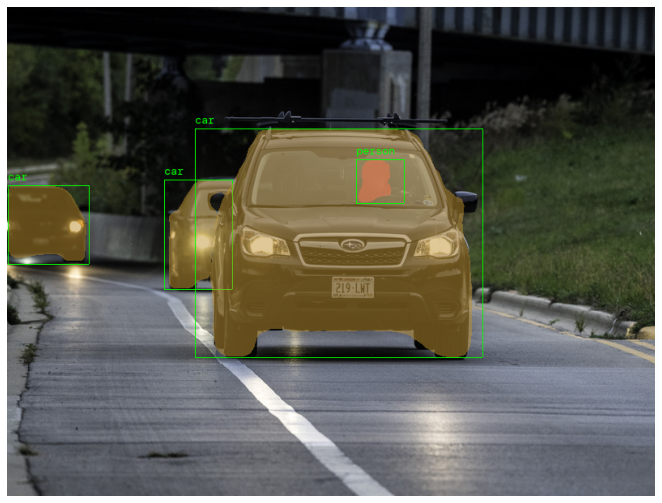

In [5]:
from itertools import cycle
import seaborn as sns
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

#### debug ####
import time


# 20 colours palette
colours = cycle(sns.color_palette("husl", 20))

cols = {}
for ele in COCO_CLASS_NAMES:
    cols[ele] = next(colours)



def get_prediction(img, confidence):
    
    # transform to tensor for the model
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    # get prediction
    model.eval()
    with torch.no_grad():
        pred = model([img])


    pred_score = list(pred[0]['scores'].detach().numpy())
    # select prediction > than confidence
    pred_t = [pred_score.index(x) for x in pred_score if x > confidence][-1]
    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())

    # get the label name
    pred_class = [COCO_CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    # get bbox
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].detach().numpy())]

    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    

    return masks, pred_boxes, pred_class

def apply_mask(image, mask, color, alpha=0.5):
    # Apply the given mask to the image.
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                    (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def apply_bbox(image, bbox, color):
    # image: np.array
    # bbox format = (x1, y1, x2, y2)
    # color: np.array [r, g, b], dtype=np.uint8

    
    # avoiding index out of bound (when a bbox coordinate is equal to a dimension of the image)
    bbox = list(bbox)
    if image.shape[0] in bbox:
        bbox = [image.shape[0] - 1 if x == image.shape[0] else x for x in bbox]
    if image.shape[1] in bbox:
        bbox = [image.shape[1] - 1 if x == image.shape[1] else x for x in bbox]

    # up and left
    image[bbox[1], bbox[0]:bbox[2]] = color
    image[bbox[1]:bbox[3], bbox[0]] = color
    # bottom and right
    image[bbox[3], bbox[0]:bbox[2]] = color
    image[bbox[1]:bbox[3], bbox[2]] = color

    return image


def apply_text(image, text, position):
    # image: numpy array
    # text: string
    # position: x1, y1 of the bbox (upper left corner)
    img = Image.fromarray(image)
    font = ImageFont.truetype("~/Library/Fonts/DMMono-Regular.ttf", int(image.shape[1]/55))
    draw = ImageDraw.Draw(img)
    draw.text(position, text, (0,255,0), font=font)

    return np.array(img)


def segment_instance(img, confidence = 0.5):
    img = np.array(img)
    masks, boxes, pred_cls = get_prediction(img, confidence)

    # drawing on image masks, bboxes and texts
    for i in range(len(masks)):
        img = apply_mask(img, masks[i], cols[pred_cls[i]])

        # boxes[i] = [x1, y1, x2, y2] where x1, y1 is the top left; x2, y2 is the bottom right
        bbox = tuple(int(np.floor(ele)) for ele in boxes[i])

        img = apply_bbox(img, bbox, np.array([0, 255, 0], dtype=np.uint8))
        img = apply_text(img, text = pred_cls[i], position = (bbox[0], bbox[1] - img.shape[1]/40))
        # ax.text(x1, (y1 - 15), str(pred_cls[i]), verticalalignment = 'top', color = 'white', fontsize = 20, weight = 'bold')

    return img


#### debug ####


img = segment_instance(Image.open('./traffic.jpg'), confidence=0.6)
# img = segment_instance(Image.open('./examples/prova.jpg'), confidence=0.7)

fig, ax = plt.subplots(1, figsize = (16, 9))
ax.set_axis_off()
plt.imshow(img)
plt.show()


### Tryng to use ffmpeg without opencv

In [190]:
import ffmpeg
from tqdm import tqdm

try:
    probe = ffmpeg.probe('./examples/FSD_small.mp4')
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    width = int(video_stream['width'])
    height = int(video_stream['height'])
    duration = float(video_stream['duration'])
except ffmpeg.Error as e:
    print(e.stderr)

out, err = (ffmpeg
    .input('./examples/FSD_small.mp4')
    .output('pipe:', format='rawvideo', pix_fmt = 'rgb24')
    .run(capture_stdout = True)
)


video = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])

# fig, ax = plt.subplots(1, figsize = (16, 9))
# ax.set_axis_off()
# plt.imshow(video[1])
# plt.show()
# 
# img = segment_instance(video[1], confidence=0.6)
# fig, ax = plt.subplots(1, figsize = (16, 9))
# ax.set_axis_off()
# plt.imshow(img)
# plt.show()

frames = []
# segment_instance
for frame in tqdm(video):
    frames.append(segment_instance(frame, confidence = 0.66))


import imageio
imageio.mimwrite('FSD_small_final.mp4', frames , fps = 30.0)


ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 12.0.1
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1645955491330/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1645955491330/_build_env/bin/pkg-config --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1645955491330/_build_env/bin/x86_64-apple-darwin13.4.0-c

### old with cv2

In [82]:
vidcap = cv2.VideoCapture('./examples/FSD.mp4')
#success, image = vidcap.read()
# print(vidcap.get(cv2.CAP_PROP_FPS)) # fps

success = True
count = 0
frames_class = []


for ele in tqdm(range(int(vidcap.get(7)))):
    if success:
        success, image = vidcap.read()
        frames_class.append(segment_instance(image, confidence=0.7))
        count += 1
    else:
        print(f'something went wrong in {count}')

100%|██████████| 2089/2089 [1:57:54<00:00,  3.39s/it] 


In [86]:
import pickle

with open("test_d", "wb") as fp:   #Pickling
    pickle.dump(frames_class, fp)

#>>> with open("test", "rb") as fp:   # Unpickling
#...   b = pickle.load(fp)

In [177]:
height, width, layers = frames[0].shape

final_video = cv2.VideoWriter('final.avi', 0, 30, (width, height))

for image in tqdm(frames):
    final_video.write(image)

cv2.destroyAllWindows()
final_video.release()

100%|██████████| 31/31 [00:00<00:00, 574.20it/s]
